In [350]:
#importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

### Import Data

In [351]:
X_train = pd.read_csv('X_train_loan_data.csv', index_col = 0)
X_test = pd.read_csv('X_test_loan_data.csv', index_col = 0)
y_train = pd.read_csv('y_train_loan_data.csv', index_col = 0)
y_test = pd.read_csv('y_test_loan_data.csv', index_col = 0)

In [352]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((21497, 8), (5375, 8), (21497, 1), (5375, 1))

In [353]:
X_train.head()

,hpi_time,uer_time,FICO_orig_time,MOB,cep_time,Vintage1,Vintage2,Vintage3
3566,-0.141930,-0.143219,0.247245,-0.648568,0.20713,1,0,0
14626,-0.141930,-0.143219,-0.654460,0.287173,0.00000,0,0,1
6600,0.128576,0.128576,0.044093,0.287173,0.20713,0,0,1
9533,0.128576,0.128576,-0.654460,-0.013995,0.00000,0,0,0
24356,-0.141930,-0.143219,0.247245,-0.013995,0.00000,0,0,1


In [354]:
y_train.head()

,status_performance
3566,0.0
14626,0.0
6600,0.0
9533,0.0
24356,0.0


### Logistic Regression

In [355]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [356]:
reg = LogisticRegression()

In [357]:
reg.fit(X_train, y_train)

LogisticRegression()

In [358]:
reg.intercept_

array([-1.35587801])

In [359]:
reg.coef_

array([[ 0.91126386, -0.12375141,  1.1679811 ,  1.07359111,  1.63647025,
        -0.2683344 , -0.26715164, -0.09248865]])

In [360]:
X_train.columns

Index(['hpi_time', 'uer_time', 'FICO_orig_time', 'MOB', 'cep_time', 'Vintage1',
       'Vintage2', 'Vintage3'],
      dtype='object')

In [361]:
feature_names = X_train.columns.values

summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_names)
summary_table['Coefficients'] = np.transpose(reg.coef_)
summary_table.index = summary_table.index + 1
summary_table.loc[0] = ['Intercept', reg.intercept_[0]]
summary_table = summary_table.sort_index()
summary_table

,Feature name,Coefficients
0,Intercept,-1.355878
1,hpi_time,0.911264
2,uer_time,-0.123751
3,FICO_orig_time,1.167981
4,MOB,1.073591
5,cep_time,1.636470
6,Vintage1,-0.268334
7,Vintage2,-0.267152
8,Vintage3,-0.092489


In [362]:
import numpy as np
from sklearn import linear_model
import scipy.stats as stat

class LogisticRegression_with_p_values:
    
    def __init__(self, *args, **kwargs):
        self.model = linear_model.LogisticRegression(*args, **kwargs)
    
    def fit(self, X, y, batch_size=1000):
        # Ensure X is a numpy array with float64 type
        X = np.asarray(X, dtype=np.float64)
        y = np.asarray(y, dtype=np.float64)
        
        self.model.fit(X, y)
        
        p = X.shape[1]  # Number of features
        F_ij = np.zeros((p, p), dtype=np.float64)  # Fisher Information Matrix
        
        num_samples = X.shape[0]
        for start in range(0, num_samples, batch_size):
            end = min(start + batch_size, num_samples)
            X_batch = X[start:end]
            
            # Ensure batch is also float64
            X_batch = np.asarray(X_batch, dtype=np.float64)
            
            decision_function_batch = self.model.decision_function(X_batch)
            
            # Compute probabilities for batch
            exp_df_batch = np.exp(-decision_function_batch)
            prob_batch = exp_df_batch / (1 + exp_df_batch)**2
            prob_batch = np.reshape(prob_batch, (X_batch.shape[0], 1))
            W_batch = np.diagflat(prob_batch)
            
            # Compute XtW for the current batch and update Fisher Information Matrix
            XtW_batch = np.dot(X_batch.T, W_batch)
            F_ij += np.dot(XtW_batch, X_batch)
        
        # Inverse Fisher Information Matrix
        try:
            Cramer_Rao = np.linalg.inv(F_ij)
        except np.linalg.LinAlgError:
            # Use pseudoinverse if the matrix is singular
            Cramer_Rao = np.linalg.pinv(F_ij)
        
        # Standard errors of the coefficients
        sigma_estimates = np.sqrt(np.diagonal(Cramer_Rao))
        
        # Z-scores
        z_scores = self.model.coef_[0] / sigma_estimates
        
        # Two-tailed p-values
        p_values = [stat.norm.sf(abs(z)) * 2 for z in z_scores]
        
        # Store results
        self.coef_ = self.model.coef_
        self.intercept_ = self.model.intercept_
        self.p_values = p_values

In [363]:
reg = LogisticRegression_with_p_values()

In [364]:
reg.fit(X_train, y_train)

In [365]:
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_names)
summary_table['Coefficients'] = np.transpose(reg.coef_)
summary_table.index = summary_table.index + 1
summary_table.loc[0] = ['Intercept', reg.intercept_[0]]
summary_table = summary_table.sort_index()
summary_table

,Feature name,Coefficients
0,Intercept,-1.355878
1,hpi_time,0.911264
2,uer_time,-0.123751
3,FICO_orig_time,1.167981
4,MOB,1.073591
5,cep_time,1.636470
6,Vintage1,-0.268334
7,Vintage2,-0.267152
8,Vintage3,-0.092489


In [366]:
p_values = reg.p_values

In [367]:
p_values = np.append(np.nan, np.array(p_values))

In [368]:
summary_table['p_values'] = p_values

summary_table['is_significant_5'] = summary_table['p_values'].apply(lambda x: 'Yes' if x < 0.05 else 'No')
summary_table['is_significant_10'] = summary_table['p_values'].apply(lambda x: 'Yes' if x < 0.10 else 'No')

In [369]:
summary_table

,Feature name,Coefficients,p_values,is_significant_5,is_significant_10
0,Intercept,-1.355878,NaN,No,No
1,hpi_time,0.911264,3.011359e-01,No,No
2,uer_time,-0.123751,8.890591e-01,No,No
3,FICO_orig_time,1.167981,1.995050e-92,Yes,Yes
4,MOB,1.073591,2.477919e-73,Yes,Yes
5,cep_time,1.636470,3.590048e-112,Yes,Yes
6,Vintage1,-0.268334,3.435650e-03,Yes,Yes
7,Vintage2,-0.267152,7.813931e-05,Yes,Yes
8,Vintage3,-0.092489,1.733657e-04,Yes,Yes


In [370]:
#takes 0.5 as default threshold for good/bad
y_hat_test = reg.model.predict(X_test)

In [371]:
y_hat_test

array([0., 1., 0., ..., 0., 0., 0.])

In [372]:
y_hat_test_prob = reg.model.predict_proba(X_test)
y_hat_test_prob

array([[0.86147669, 0.13852331],
       [0.45538688, 0.54461312],
       [0.51401686, 0.48598314],
       ...,
       [0.7019617 , 0.2980383 ],
       [0.824356  , 0.175644  ],
       [0.72545313, 0.27454687]])

In [373]:
y_hat_test_prob_good = y_hat_test_prob[:][:,0]
y_hat_test_prob_good

array([0.86147669, 0.45538688, 0.51401686, ..., 0.7019617 , 0.824356  ,
       0.72545313])

In [374]:
y_test_temp = y_test

In [375]:
y_test_temp.reset_index(drop = True, inplace = True)

In [376]:
df_actual_predicted_prob = pd.concat([y_test_temp,pd.DataFrame(y_hat_test_prob_good)], axis = 1)

In [377]:
df_actual_predicted_prob.shape

(5375, 2)

In [378]:
df_actual_predicted_prob.columns = ['y_test', 'y_hat_test_prob_good']

In [379]:
df_actual_predicted_prob.index = X_test.index

In [380]:
df_actual_predicted_prob.head()

,y_test,y_hat_test_prob_good
9330,1.0,0.861477
4161,0.0,0.455387
18501,1.0,0.514017
8841,0.0,0.725453
5099,0.0,0.896182


### Accuracy and Area under the curve

In [381]:
#threshold
tr = 0.4

In [382]:
df_actual_predicted_prob['y_hat_test'] = np.where(df_actual_predicted_prob['y_hat_test_prob_good'] > tr, 0, 1)

In [383]:
df_actual_predicted_prob.head()

,y_test,y_hat_test_prob_good,y_hat_test
9330,1.0,0.861477,0
4161,0.0,0.455387,0
18501,1.0,0.514017,0
8841,0.0,0.725453,0
5099,0.0,0.896182,0


In [384]:
pd.crosstab(df_actual_predicted_prob['y_test'],df_actual_predicted_prob['y_hat_test'], 
            rownames = ['Actual'], colnames = ['Predicted'])

Predicted,0,1
Actual,,
0.0,4077,14
1.0,1258,26


In [385]:
#Confusion matrix
confusion_matrix = pd.crosstab(df_actual_predicted_prob['y_test'],df_actual_predicted_prob['y_hat_test'], 
            rownames = ['Actual'], colnames = ['Predicted']) / df_actual_predicted_prob.shape[0]
confusion_matrix

Predicted,0,1
Actual,,
0.0,0.758512,0.002605
1.0,0.234047,0.004837


In [386]:
accuracy_score = confusion_matrix.iloc[0,0] + confusion_matrix.iloc[1,1]

In [387]:
accuracy_score

0.7633488372093024

In [388]:
precision = confusion_matrix.iloc[1,1] / (confusion_matrix.iloc[1,1] + confusion_matrix.iloc[0,1])
precision

0.65

In [389]:
recall = confusion_matrix.iloc[1,1] / (confusion_matrix.iloc[1,1] + confusion_matrix.iloc[1,0])
recall

0.020249221183800622

In [390]:
from sklearn.metrics import roc_curve, roc_auc_score

In [391]:
roc_curve(df_actual_predicted_prob['y_test'],df_actual_predicted_prob['y_hat_test'])

(array([0.        , 0.00342215, 1.        ]),
 array([0.        , 0.02024922, 1.        ]),
 array([2, 1, 0]))

In [392]:
fpr, tpr, thresholds = roc_curve(df_actual_predicted_prob['y_test'],df_actual_predicted_prob['y_hat_test_prob_good'])

Text(0.5, 1.0, 'ROC curve')

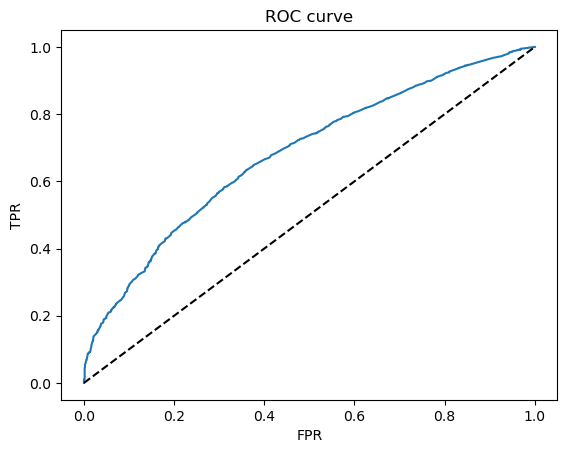

In [393]:
plt.plot(tpr, fpr)
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')

In [394]:
AUCROC = roc_auc_score(df_actual_predicted_prob['y_test'],1-df_actual_predicted_prob['y_hat_test_prob_good'])
AUCROC

0.6809013364950491

### Gini and Kolmogorov-Smirno

In [395]:
df_actual_predicted_prob = df_actual_predicted_prob.sort_values('y_hat_test_prob_good')

In [396]:
df_actual_predicted_prob = df_actual_predicted_prob.reset_index()
df_actual_predicted_prob.head()

,index,y_test,y_hat_test_prob_good,y_hat_test
0,1775,0.0,0.289185,1
1,25177,1.0,0.289185,1
2,26705,1.0,0.289185,1
3,16785,1.0,0.289185,1
4,25785,1.0,0.307428,1


In [397]:
df_actual_predicted_prob['Cumm Population'] = df_actual_predicted_prob.index + 1
df_actual_predicted_prob['Cumm Bad'] =  df_actual_predicted_prob['y_test'].cumsum()
df_actual_predicted_prob['Cumm Good'] = df_actual_predicted_prob['Cumm Population'] - df_actual_predicted_prob['y_test'].cumsum()

In [398]:
df_actual_predicted_prob['Cumm perc population'] = df_actual_predicted_prob['Cumm Population'] / df_actual_predicted_prob.shape[0]
df_actual_predicted_prob['Cumm perc good'] = df_actual_predicted_prob['Cumm Good'] / (df_actual_predicted_prob.shape[0] - df_actual_predicted_prob['y_test'].sum())
df_actual_predicted_prob['Cumm perc bad'] = df_actual_predicted_prob['Cumm Bad'] / df_actual_predicted_prob['y_test'].sum()

Text(0.5, 1.0, 'Gini')

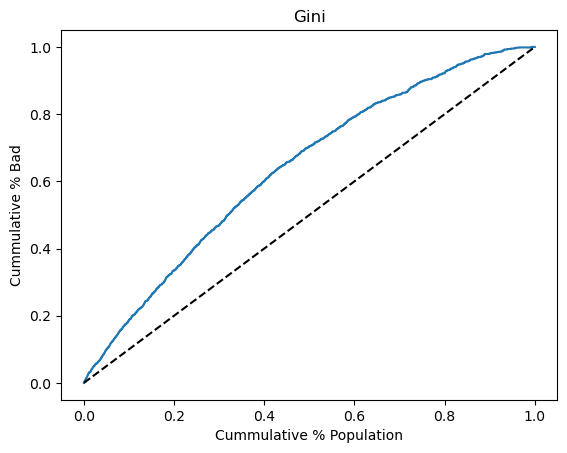

In [399]:
#Gini coefficient
plt.plot(df_actual_predicted_prob['Cumm perc population'], df_actual_predicted_prob['Cumm perc bad'])
plt.plot(df_actual_predicted_prob['Cumm perc population'], df_actual_predicted_prob['Cumm perc population'], linestyle = '--', color = 'k')
plt.xlabel('Cummulative % Population')
plt.ylabel('Cummulative % Bad')
plt.title('Gini')

In [400]:
gini = 2*AUCROC - 1
gini

0.3618026729900983

Text(0.5, 1.0, 'Kolmogorov-Smirnov')

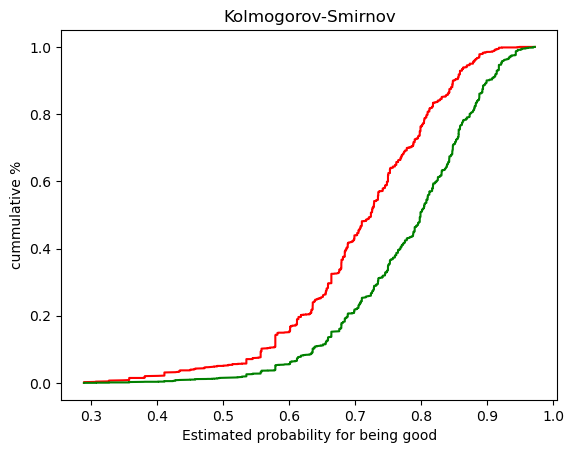

In [401]:
plt.plot(df_actual_predicted_prob['y_hat_test_prob_good'],df_actual_predicted_prob['Cumm perc bad'], color = 'r')
plt.plot(df_actual_predicted_prob['y_hat_test_prob_good'],df_actual_predicted_prob['Cumm perc good'], color = 'g')
plt.xlabel('Estimated probability for being good')
plt.ylabel('cummulative %')
plt.title('Kolmogorov-Smirnov')

In [402]:
KS = max(df_actual_predicted_prob['Cumm perc bad'] - df_actual_predicted_prob['Cumm perc good'])
KS

0.2737728362007324

### Decision tree

In [403]:
from sklearn.tree import DecisionTreeClassifier

In [404]:
treeClassifier = DecisionTreeClassifier()

In [405]:
treeClassifier.fit(X_train, y_train)

DecisionTreeClassifier()

In [406]:
parameter = {
    'criterion' : ['gini','entropy','log_loss'],
    'splitter' : ['best','random'],
    'max_depth' : [1,2,3,4,5],
    'max_features' : ['auto','sqrt','log2']
}

In [407]:
from sklearn.model_selection import GridSearchCV

In [408]:
clf = GridSearchCV(DecisionTreeClassifier(),
            param_grid = parameter,
            cv = 5,
            scoring = 'accuracy')

clf

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [1, 2, 3, 4, 5],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'splitter': ['best', 'random']},
             scoring='accuracy')

In [409]:
## Train the data
clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [1, 2, 3, 4, 5],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'splitter': ['best', 'random']},
             scoring='accuracy')

In [410]:
clf.best_params_

{'criterion': 'gini',
 'max_depth': 4,
 'max_features': 'log2',
 'splitter': 'random'}

In [411]:
y_pred = clf.predict(X_test)

In [412]:
from sklearn.metrics import accuracy_score, classification_report

In [413]:
score = accuracy_score(y_pred, y_test)
print(score)

0.7629767441860466


In [414]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

         0.0       0.98      0.77      0.86      5227
         1.0       0.06      0.53      0.11       148

    accuracy                           0.76      5375
   macro avg       0.52      0.65      0.49      5375
weighted avg       0.96      0.76      0.84      5375



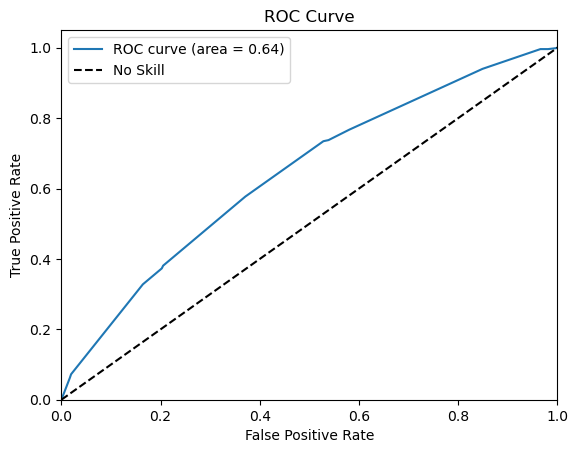

In [415]:
from sklearn.metrics import roc_curve, auc

# Predict probabilities on the test set
y_pred_proba = clf.predict_proba(X_test)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba) 
roc_auc = auc(fpr, tpr)
# Plot the ROC curve
plt.figure()  
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [416]:
gini = 2*roc_auc - 1
gini

0.28431702902275413

### Random Forest

In [417]:
from sklearn.ensemble import RandomForestClassifier

In [418]:
rf_classifier = RandomForestClassifier()

In [419]:
rf_classifier

RandomForestClassifier()

In [420]:
parameter = {
    'criterion' : ['gini','entropy','log_loss'],
    'max_depth' : [1,2,3,4,5,6,7,8],
    'max_features' : ['sqrt','log2']
}

In [421]:
clf = GridSearchCV(RandomForestClassifier(),
            param_grid = parameter,
            cv = 5,
            scoring = 'accuracy')

clf

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8],
                         'max_features': ['sqrt', 'log2']},
             scoring='accuracy')

In [422]:
clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8],
                         'max_features': ['sqrt', 'log2']},
             scoring='accuracy')

In [423]:
clf.best_params_

{'criterion': 'log_loss', 'max_depth': 8, 'max_features': 'sqrt'}

In [424]:
y_pred = clf.predict(X_test)

In [425]:
score = accuracy_score(y_pred, y_test)
print(score)

0.761860465116279


In [426]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

         0.0       0.99      0.76      0.86      5309
         1.0       0.03      0.53      0.05        66

    accuracy                           0.76      5375
   macro avg       0.51      0.65      0.46      5375
weighted avg       0.98      0.76      0.85      5375



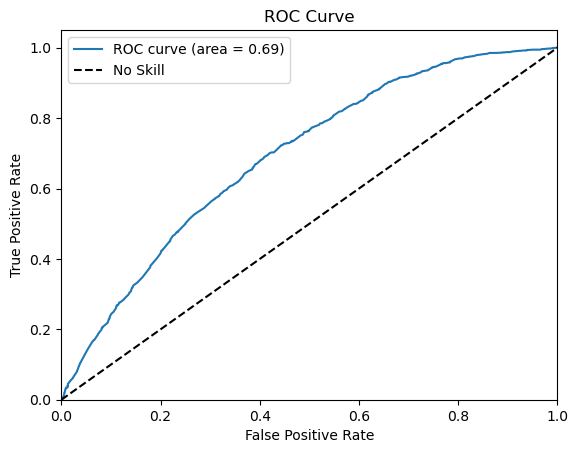

In [427]:
from sklearn.metrics import roc_curve, auc

# Predict probabilities on the test set
y_pred_proba = clf.predict_proba(X_test)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba) 
roc_auc = auc(fpr, tpr)
# Plot the ROC curve
plt.figure()  
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [428]:
gini = 2*roc_auc - 1
gini

0.38179165419723105

## AdaBoost

In [429]:
from sklearn.ensemble import AdaBoostClassifier

In [430]:
ab_classifier = AdaBoostClassifier()

In [431]:
ab_classifier

AdaBoostClassifier()

In [432]:
# Choosing Decision Tree with 1 level as the weak learner
DTC=DecisionTreeClassifier(max_depth=1)
clf = AdaBoostClassifier(base_estimator=DTC)

In [433]:
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.77      0.97      0.86      4091
         1.0       0.47      0.07      0.13      1284

    accuracy                           0.76      5375
   macro avg       0.62      0.52      0.49      5375
weighted avg       0.70      0.76      0.69      5375



In [434]:
parameters = {
    'n_estimators' : [50, 70, 90, 120, 180, 200],
    'learning_rate' : [0.001, 0.01, 0.1, 1, 10]
}

grid_search = GridSearchCV(ab_classifier, parameters, n_jobs = -1, cv = 5, verbose = 1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=5, estimator=AdaBoostClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.001, 0.01, 0.1, 1, 10],
                         'n_estimators': [50, 70, 90, 120, 180, 200]},
             verbose=1)

In [435]:
grid_search.best_params_

{'learning_rate': 0.1, 'n_estimators': 90}

In [436]:
ada=AdaBoostClassifier(base_estimator=DTC,learning_rate= 0.1, n_estimators= 90) 

ada.fit(X_train,y_train)

y_pred=ada.predict(X_test)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.76      1.00      0.86      4091
         1.0       0.62      0.01      0.02      1284

    accuracy                           0.76      5375
   macro avg       0.69      0.50      0.44      5375
weighted avg       0.73      0.76      0.66      5375



In [437]:
# Printing the Overall Accuracy of the model
F1_Score=metrics.f1_score(y_test, y_pred, average='weighted')
print('Accuracy of the model on Testing Sample Data:', round(F1_Score,2))

Accuracy of the model on Testing Sample Data: 0.66


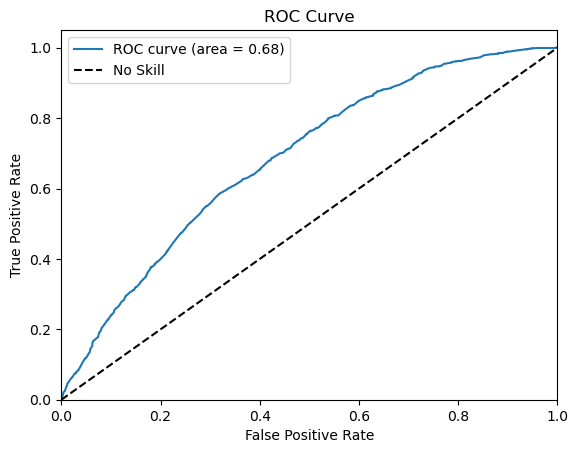

In [438]:
from sklearn.metrics import roc_curve, auc

# Predict probabilities on the test set
y_pred_proba = clf.predict_proba(X_test)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba) 
roc_auc = auc(fpr, tpr)
# Plot the ROC curve
plt.figure()  
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [439]:
gini = 2*roc_auc - 1
gini

0.3693854224492483

## XGBoost

In [440]:
from xgboost import XGBClassifier

In [441]:
xgb_classifier = XGBClassifier()

In [442]:
xgb_classifier

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [443]:
parameters = {
    'loss': ['log_loss', 'exponential'],
    'criterion': ['friedman_mse', 'squared_error'],
    'max_features': ['sqrt', 'log2'],
    'learning_rate' : [0.001, 0.01, 0.1, 1, 10],
    'n_estimators' : [50, 70, 90, 120, 180, 200],
    'reg_alpha': [1e-5, 1e-2, 0.1, 100]
}

grid_search = GridSearchCV(xgb_classifier, parameters, n_jobs = -1, cv = 5, verbose = 1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 960 candidates, totalling 4800 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'criterion': ['friedman_mse', 'squared_error'],
                         'learning_rate': [0.001, 0.01, 0.1, 1, 10],
                         'loss': ['log_loss', 'exponential'],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [50, 70, 90, 120, 180, 200],
                         'reg_alpha': [1e-05, 0.01, 0.1, 100]},
             verbose=1)

In [444]:
grid_search.best_params_

{'criterion': 'friedman_mse',
 'learning_rate': 0.1,
 'loss': 'log_loss',
 'max_features': 'sqrt',
 'n_estimators': 70,
 'reg_alpha': 0.1}

In [445]:
param_test = {
    'reg_alpha':[1e-5, 1e-2, 0.1, 100]
}

XGB = GridSearchCV(
    estimator = XGBClassifier(
        criterion = 'friedman_mse', learning_rate = 0.1, loss = 'log_loss', max_features = 'sqrt', n_estimators = 70, reg_alpha = 0.1
    ),
    param_grid = param_test, scoring='roc_auc',n_jobs=4,cv=5,verbose=10
)

XGB.fit(X_train,y_train)

y_pred=XGB.predict(X_test)

print(classification_report(y_test,y_pred))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
              precision    recall  f1-score   support

         0.0       0.77      0.98      0.86      4091
         1.0       0.50      0.05      0.09      1284

    accuracy                           0.76      5375
   macro avg       0.63      0.52      0.47      5375
weighted avg       0.70      0.76      0.68      5375



In [446]:
# Printing the Overall Accuracy of the model
F1_Score=metrics.f1_score(y_test, y_pred, average='weighted')
print('Accuracy of the model on Testing Sample Data:', round(F1_Score,2))

Accuracy of the model on Testing Sample Data: 0.68


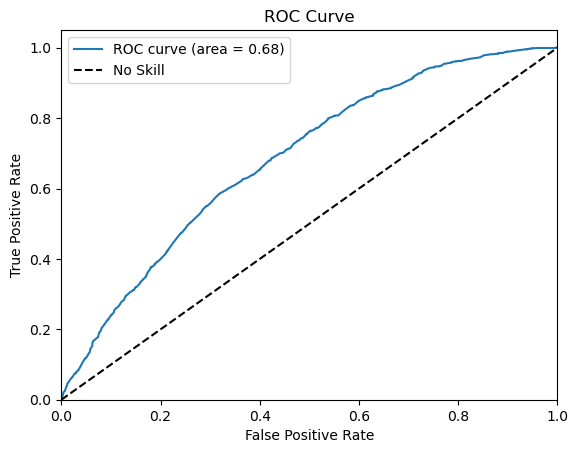

In [447]:
from sklearn.metrics import roc_curve, auc

# Predict probabilities on the test set
y_pred_proba = clf.predict_proba(X_test)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba) 
roc_auc = auc(fpr, tpr)
# Plot the ROC curve
plt.figure()  
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [448]:
gini = 2*roc_auc - 1
gini

0.3693854224492483

## Naive Bayes

In [449]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()

gnb.fit(X_train, y_train)

GaussianNB()

In [450]:
y_pred = gnb.predict(X_test)

In [451]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [452]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

[[3175  916]
 [ 739  545]]
              precision    recall  f1-score   support

         0.0       0.81      0.78      0.79      4091
         1.0       0.37      0.42      0.40      1284

    accuracy                           0.69      5375
   macro avg       0.59      0.60      0.60      5375
weighted avg       0.71      0.69      0.70      5375

0.6920930232558139


In [453]:
from sklearn.model_selection import RepeatedStratifiedKFold

cv_method = RepeatedStratifiedKFold(n_splits=5, 
                                    n_repeats=3, 
                                    random_state=999)

from sklearn.preprocessing import PowerTransformer
params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}

gs_NB = GridSearchCV(estimator=gnb, 
                     param_grid=params_NB, 
                     cv=cv_method,
                     verbose=1, 
                     scoring='accuracy')

Data_transformed = PowerTransformer().fit_transform(X_test)

gs_NB.fit(Data_transformed, y_test);

Fitting 15 folds for each of 100 candidates, totalling 1500 fits


In [454]:
gs_NB.best_params_

{'var_smoothing': 1.0}

In [455]:
gs_NB.best_score_

0.762418604651163

In [456]:
results_NB = pd.DataFrame(gs_NB.cv_results_['params'])
results_NB['test_score'] = gs_NB.cv_results_['mean_test_score']

In [457]:
# predict the target on the test dataset
predict_test = gs_NB.predict(Data_transformed)

# Accuracy Score on test dataset
accuracy_test = accuracy_score(y_test,predict_test)
print('accuracy_score on test dataset : ', accuracy_test)

accuracy_score on test dataset :  0.7626046511627907


In [458]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

[[3175  916]
 [ 739  545]]
              precision    recall  f1-score   support

         0.0       0.81      0.78      0.79      4091
         1.0       0.37      0.42      0.40      1284

    accuracy                           0.69      5375
   macro avg       0.59      0.60      0.60      5375
weighted avg       0.71      0.69      0.70      5375

0.6920930232558139


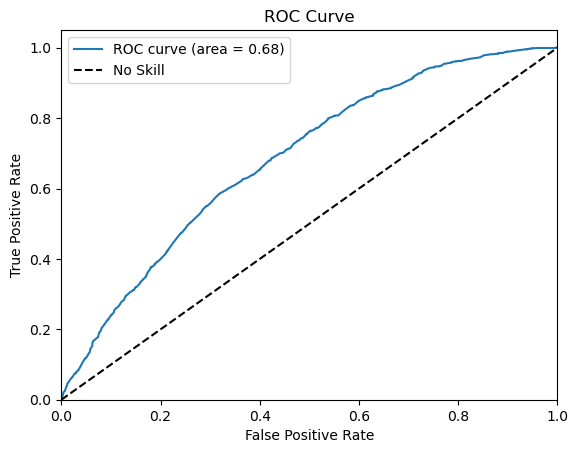

In [459]:
from sklearn.metrics import roc_curve, auc

# Predict probabilities on the test set
y_pred_proba = clf.predict_proba(X_test)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba) 
roc_auc = auc(fpr, tpr)
# Plot the ROC curve
plt.figure()  
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [460]:
gini = 2*roc_auc - 1
gini

0.3693854224492483

### KNN

In [461]:
from sklearn.neighbors import KNeighborsClassifier

In [462]:
classifier = KNeighborsClassifier(
    n_neighbors=10,
    algorithm='auto'
)

classifier.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=10)

In [463]:
y_pred = classifier.predict(X_test)

In [464]:
print(accuracy_score(y_pred, y_test))
print(confusion_matrix(y_pred, y_test))
print(classification_report(y_pred, y_test)) 

0.753860465116279
[[3947 1179]
 [ 144  105]]
              precision    recall  f1-score   support

         0.0       0.96      0.77      0.86      5126
         1.0       0.08      0.42      0.14       249

    accuracy                           0.75      5375
   macro avg       0.52      0.60      0.50      5375
weighted avg       0.92      0.75      0.82      5375



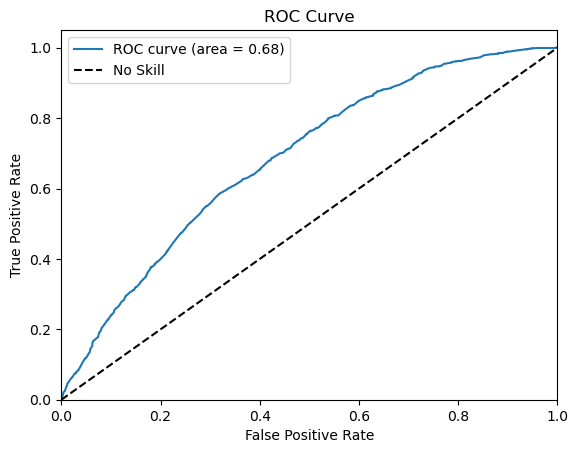

In [465]:
from sklearn.metrics import roc_curve, auc

# Predict probabilities on the test set
y_pred_proba = clf.predict_proba(X_test)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba) 
roc_auc = auc(fpr, tpr)
# Plot the ROC curve
plt.figure()  
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [466]:
gini = 2*roc_auc - 1
gini

0.3693854224492483